In [2]:
from utilities.imports import *

dict_keys(['__header__', '__version__', '__globals__', 'file_name', 'timesteps', 'xSize', 'ySize', 'anglesPerTimestep', 'image', 'A', 'f', 'angleVec', 'gtFlow'])


## Load the data from the .mat file

In [16]:

mat_data = scipy.io.loadmat("data/pinball/data_30Time_1RandEach")

# Access the variables in the .mat file
print(mat_data.keys())  # T
V_true = mat_data["image"]
A_bar = mat_data["A"]
y = mat_data["f"]
u=mat_data["gtFlow"]
Aseq = [A_bar[i*75:(i+1)*75, i*2500:(i+1)*2500] for i in range(30)]
#Aseq =  AC
B = y.T
#B_true = np.array(y_true)
t_end= 10
nt =t_end
t_0 = 0
step = 1

nx=V_true.shape[0]
ny=nx
shape = (nx,ny)

I = sparse.identity(1)
I_bar = scipy.sparse.block_diag([I for i in range(t_0,t_0+t_end,step)]) 
A_bar_ = scipy.sparse.block_diag([Aseq[i] for i in range(t_0,t_0+t_end,step)])
Anorm = 1 #sparse.linalg.norm(A_bar_)
A_bar = A_bar_/Anorm
L = gen_first_derivative_operator_2D(nx, ny)
L_bar = scipy.sparse.block_diag([L for i in range(t_0,t_end,step)]) #pylops.BlockDiag([L for i in range(0,t_end)])
data_vec_bar = vec(np.array([B[t] for t in  range(t_0,t_0+t_end,step)])).reshape(-1,1)/Anorm
truth =vec(np.array([vec(V_true[:,:,t].T) for t in  range(t_0,t_0+t_end,step)]))
t_end = len([B[i] for i in range(t_0,t_0+t_end,step)])
nt = t_end
X_true = truth.reshape(-1,1)
data_vec_true_bar = (A_bar_@X_true)/Anorm
delta = la.norm(data_vec_bar-data_vec_true_bar)

dict_keys(['__header__', '__version__', '__globals__', 'file_name', 'timesteps', 'xSize', 'ySize', 'anglesPerTimestep', 'image', 'A', 'f', 'angleVec', 'gtFlow'])


7.0952373931910175

In [ ]:
size = nx*ny
shape = (nx,ny)
nt = t_end
L_space_time = gen_spacetime_derivative_operator(nx, ny, nt)

n_iter = 100  #number of iterations in th MM-GKS-OF algorithm
proj_dim = 10 # initial subspace dimension in the MM-GKS-OF algorithm
vs_true = None # the forward velocity fields
v_primes_true= None # the reverse velocity fields
epsilon = 1e-2 #the smoothing parameter for the MM-GKS-OF algorithm
non_neg =  True # whether to enforce non-negativity for the image
regparam = 'dp' # regularization parameter for the MM-GKS-OF algorithm
x0= None #X_true.reshape((-1,1)) # initial guess for the MM-GKS-OF algorithm
power = 1/2

n_iter_b = 20 # number of iterations in the SOLVE-OF algorithm
reduction = True # whether to scale the images when estimating the velocity fields
scale = 2 # scaling factor for the images when estimating the velocity fields
v_max = 1 # maximum velocity magnitude
interval = n_iter//10 #interval for computing the optical flow e.g interval = 5 means computing the optical flow every 10 iterations
pnorm_opt = 2 # p-norm for the optical flow solver
qnorm_opt = 2 # q-norm for the optical flow solver
parallel_of = True # whether to solve the optical flow problem in parallel


all_methods = ['mmgks','mmgks-of','aniso','aniso-of','gs','gs-of','iso','iso-of']
of_methods = ['mmgks-of','aniso-of','gs-of','iso-of'] 
reg_methods = ['mmgks','aniso','gs','iso']


## Populate the methods list with the methods you want to run

In [ ]:
#enter here to select the methods you want to run
methods = ['aniso','aniso-of']

In [ ]:
def run_all_methods(method):
    if (method == 'mmgks'):
        return MMGKS2(A_bar, data_vec_bar, L_bar, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = regparam, x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta,non_neg=non_neg,power=power,x0=x0)
    elif (method == 'mmgks-of'):
        return MMGKS_OF(A_bar, data_vec_bar, L_bar, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = regparam, regparam_dyn = 'dp',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta,pnorm_opt=pnorm_opt, qnorm_opt=qnorm_opt,non_neg=non_neg,interval = interval,power=power,parallel_of = parallel_of, n_jobs=t_end,x0=x0) 
    elif(method == 'aniso'):
        return  MMGKS2(A_bar, data_vec_bar, L_space_time, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = regparam, x_true = X_true.reshape((-1,1)), epsilon=epsilon,delta=delta,non_neg=non_neg,power=power,x0=x0)
    elif (method == 'aniso-of'):
        return MMGKS_OF(A_bar, data_vec_bar, L_space_time, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = regparam, regparam_dyn = 'dp',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon,delta =delta,pnorm_opt=pnorm_opt, qnorm_opt=qnorm_opt,non_neg=non_neg,interval = interval,power=power,parallel_of = parallel_of, n_jobs=t_end,x0=x0)
    elif(method == 'gs'):
        return  MMGKS2(A_bar, data_vec_bar, L_space_time, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = regparam, x_true = X_true.reshape((-1,1)), epsilon=epsilon, GS= 'gs', prob_dims = (nx,ny, nt),delta=delta,non_neg=non_neg,power=power)
    elif (method == 'gs-of'):
        return MMGKS_OF(A_bar, data_vec_bar, L_space_time, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = regparam, regparam_dyn = 'dp',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon, GS = 'gs', prob_dims = (nx,ny, nt),delta =delta,pnorm_opt=pnorm_opt, qnorm_opt=qnorm_opt,non_neg=non_neg,interval = interval,power=power,
parallel_of = parallel_of, n_jobs=t_end,x0=x0)    
    elif(method == 'iso'):
        return  MMGKS2(A_bar, data_vec_bar, L_space_time, pnorm=2, qnorm=1, projection_dim=proj_dim, 
                        n_iter =n_iter, regparam = regparam, x_true = X_true.reshape((-1,1)), epsilon=epsilon, isoTV= 'isoTV', prob_dims = (nx,ny, nt),delta=delta,non_neg=non_neg,power=power)
    elif (method == 'iso-of'):
        return MMGKS_OF(A_bar, data_vec_bar, L_space_time, I_bar, t_end,shape,pnorm=2,
qnorm=1, rnorm=1, projection_dim=proj_dim, n_iter =n_iter, n_iter_b = n_iter_b, regparam = regparam, regparam_dyn = 'dp',vs_true = vs_true, v_primes_true=v_primes_true,  v_max=v_max, 
x_true = X_true.reshape((-1,1)), reduction = reduction, scale=scale,epsilon=epsilon, isoTV= 'isoTV', prob_dims = (nx,ny, nt),delta =delta,pnorm_opt=pnorm_opt, qnorm_opt=qnorm_opt,non_neg=non_neg,interval = interval,power=power,
parallel_of = parallel_of, n_jobs=t_end,x0=x0)

running MMGKS...: 100%|██████████| 100/100 [01:53<00:00,  1.14s/it]


## Run the cell below to run all the selected methods and compute the relative error and SSIM

In [ ]:
from multiprocessing.pool import ThreadPool

with ThreadPool(8) as p:
    result = p.map(run_all_methods, methods)
result_dict = {}
for i in range(len(methods)):
    result_dict[methods[i]] = result[i]

In [29]:
rre_dict = {}
for method in methods:
    if method in result_dict.keys():
        rre_dict[method] = result_dict[method][1]['relError']

mean_rre_dict = {}
for method in methods:
    if method in result_dict.keys():
        mean_rre_dict[method] = rre_all(result_dict[method][0],X_true,nt,nx,ny)

mean_ssim_dict = {}
for method in methods:
    if method in result_dict.keys():
        mean_ssim_dict[method] = ssim_all(result_dict[method][0],X_true,nt,nx,ny)

recovered_images_dict = {}
for method in methods:
    if method in result_dict.keys():
        recovered_images_dict[method] = result_dict[method][0]

reg_param_dict = {}
for method in methods:
    if method in result_dict.keys():
        reg_param_dict[method] = result_dict[method][1]['regParam_history']

motion_matrices_dict = {}
for method in methods:
    if ((method in result_dict.keys()) and method in of_methods):
        motion_matrices_dict[method] = result_dict[method][1]['Ms']

reverse_motion_matrices_dict = {}
for method in methods:
    if ((method in result_dict.keys()) and method in of_methods):
        reverse_motion_matrices_dict[method] = result_dict[method][1]['M_primes']

vs_est_dict = {}
for method in methods:
    if((method in result_dict.keys()) and method in of_methods):
        vs_est_dict[method] = result_dict[method][2]

v_primes_est_dict = {}
for method in methods:
    if((method in result_dict.keys()) and method in of_methods):
        v_primes_est_dict[method] = result_dict[method][3]

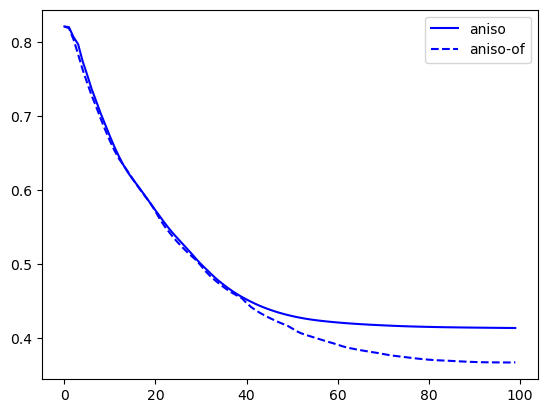

In [30]:
import pickle
ls = ['b-','b--','y-','y--','g-','g--','r-','r--']
ls_dict = {}
for i in range(len(methods)):
    ls_dict[methods[i]] = ls[i]

for method in methods:
    # print(rre_dict)
    plt.plot(rre_dict[method],ls_dict[method],label=method)
    plt.legend()

## Recovered Images

Image order, Up to Down ['aniso', 'aniso-of']


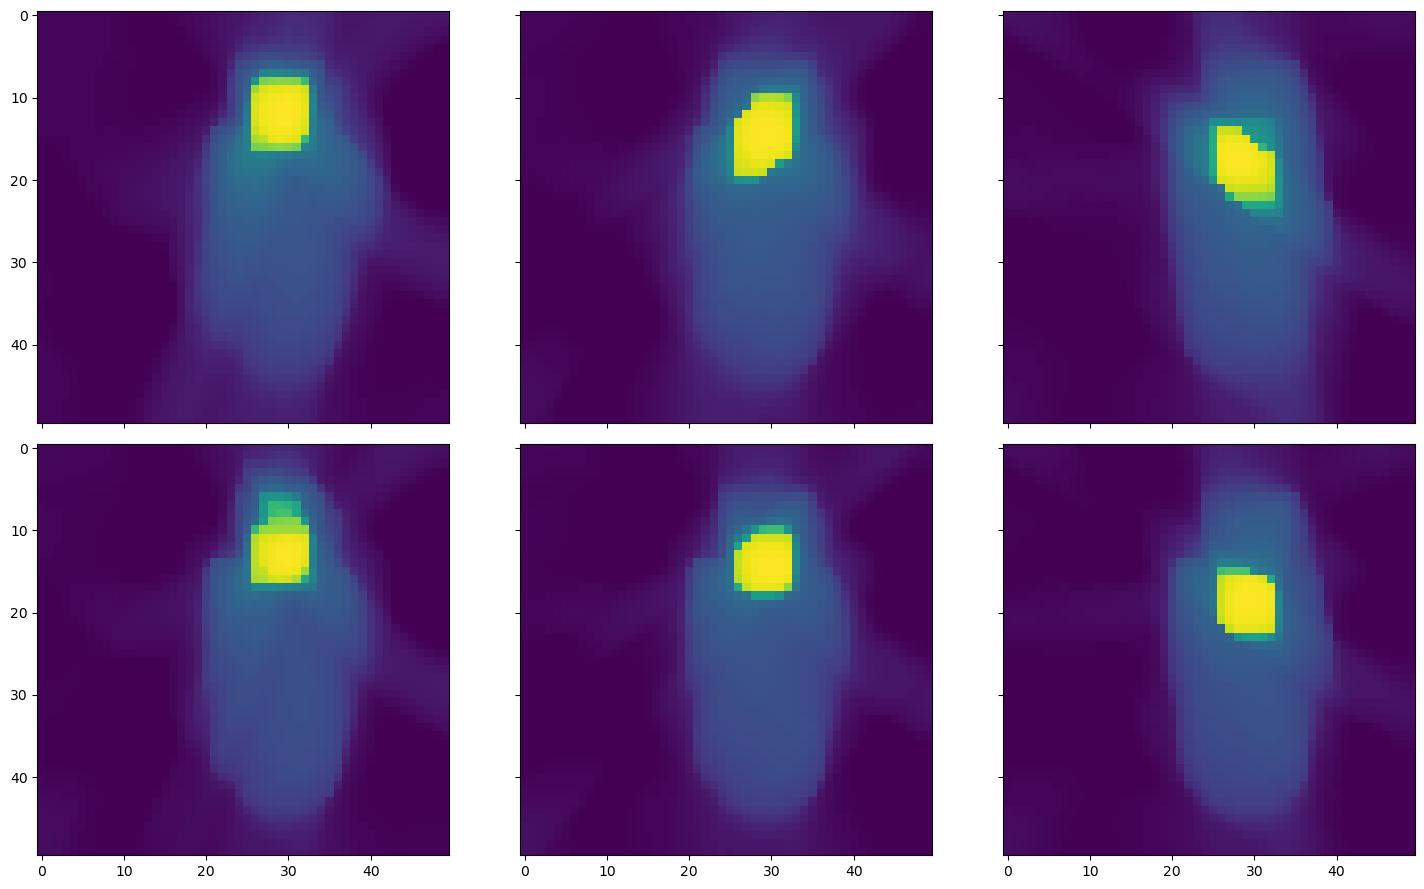

In [34]:


ts = np.linspace(1,t_end,3).astype(int)

fig,ax=plt.subplots(len(recovered_images_dict.keys()),len(ts),figsize=(15,9),sharex=True, sharey=True)


print('Image order, Up to Down', list(recovered_images_dict.keys()))
k=0
for method in recovered_images_dict.keys():
    for i in range(0,len(ts)):
        images = recovered_images_dict[method].reshape(t_end,*shape)
        ax[k,i].imshow(images[ts[i]-1].reshape(shape))
    k+=1
plt.subplots_adjust(wspace=None, hspace=None)
fig.tight_layout(h_pad=1)


## Velocity Estimates

Max Magnitude: 1.23
Mean Magnitude: 0.10
90th Percentile: 0.32
95th Percentile: 0.50
99th Percentile: 0.80


IndexError: index 9 is out of bounds for axis 0 with size 9

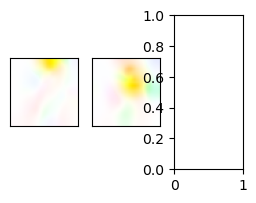

In [31]:
import flow_vis
v_est = vs_est_dict["aniso-of"]


# Compute flow magnitude
flow = v_est  # Assuming this is your flow array
magnitude = np.sqrt(np.sum(flow**2, axis=-1))  # Compute per-pixel magnitude

# Print statistics
print(f"Max Magnitude: {np.max(magnitude):.2f}")
print(f"Mean Magnitude: {np.mean(magnitude):.2f}")
print(f"90th Percentile: {np.percentile(magnitude, 90):.2f}")
print(f"95th Percentile: {np.percentile(magnitude, 95):.2f}")
print(f"99th Percentile: {np.percentile(magnitude, 99):.2f}")

lp = np.percentile(magnitude, 99)

fig,ax = plt.subplots(1, len(ts), figsize=(3, 2))
for i in range(len(ts)):
    flow_color = flow_vis.flow_to_color(np.clip(v_est[ts[i]-1][..., [1, 0]],-lp,lp), convert_to_bgr=False)
    ax[i].imshow(flow_color)
    ax[i].set_xticks([])
    ax[i].set_yticks([])